# 0. Setup

In [108]:
# Imports 
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as st
import theano.tensor as tt


# Helper functions
def plot_golf_data(data, ax=None):
    """Utility function to standardize a pretty plotting of the golf data."""
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 6))
    bg_color = ax.get_facecolor()
    ax.vlines(
        data["distance"],
        ymin=-data["se"] + data["p_hat"],
        ymax=data["se"] + data["p_hat"],
        label=None,
    )
    ax.plot(data["distance"], data["p_hat"], 'o', mfc=bg_color, label=None)
    

    ax.set_xlabel("Distance from hole")
    ax.set_ylabel("Proportion of putts made")
    ax.set_ylim(bottom=0, top=1)

    ax.set_xlim(left=0)
    ax.grid(True, axis='y', alpha=0.7)
    return ax

# 1. Introduction

The following example is based on a study by [Gelman and Nolan (2002)](http://www.stat.columbia.edu/~gelman/research/published/golf.pdf), where they use Bayesian methods to estimate the accuracy of pro golfers with respect to putting.

The data comes from Don Berry's textbook *Statistics: A Bayesian Perspective* (1995) and describes the number of tries and successes of golf putting from a range of distances.

This example is also featured in the case studies sections of the [Stan](https://mc-stan.org/users/documentation/case-studies/golf.html) and [PyMC3](https://docs.pymc.io/notebooks/putting_workflow.html) documentation. This notebook is based heavily on these two sources.

## 1.1 Data

In [109]:
# Putting data from Berry (1995)
data = pd.read_csv("golf_1995.csv", sep=",")

In [110]:
data["p_hat"] = data["successes"] / data["tries"]
data

,distance,tries,successes,p_hat
0,2,1443,1346,0.932779
1,3,694,577,0.831412
2,4,455,337,0.740659
3,5,353,208,0.589235
4,6,272,149,0.547794
5,7,256,136,0.531250
6,8,240,111,0.462500
7,9,217,69,0.317972
8,10,200,67,0.335000
9,11,237,75,0.316456


The authors start by estimating the standard error of the estimated probability of success for each distance in order to get a sense of how closely the model should be expected to fit the data, given by

$SE(\hat{p}_i) = \sqrt{\dfrac{\hat{p}_i(1 - \hat{p}_i)}{n}}$

In [111]:
def se(data):
    """Calculate standard error of estimator."""
    p_hat = data["p_hat"]
    n = data["tries"]
    return np.sqrt(p_hat * (1 - p_hat) / n)

data["se"] = se(data)

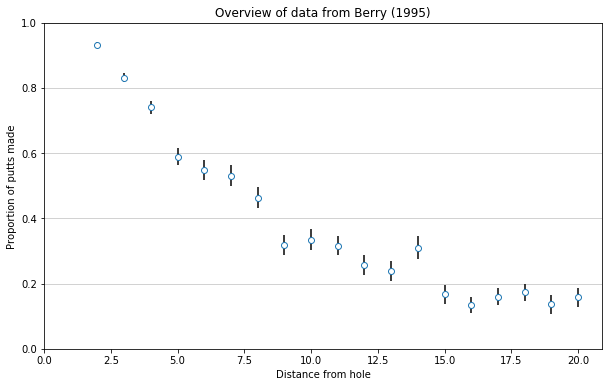

In [112]:
ax = plot_golf_data(data)
ax.set_title("Overview of data from Berry (1995)")
plt.show()

# 2. Baseline: Logit model

As a baseline model, we fit a simple logistic regression to the data, where the probability is give as a function of the distance $x_j$ from the hole. The data generating process for $y_j$ is assumed to be a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution):

$$y_j \sim \text{Binomial}(n_j, p_j),\\
p_j = \dfrac{1}{1 + e^{-(a + bx_j)}},  \quad \text{for} j = 1 \ldots J,\\
a, b \sim \text{Normal}(0, 1)$$ 

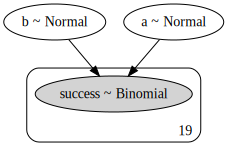

In [113]:
def logit_model(data):
    """Logistic regression model."""
    with pm.Model() as logit_binomial:
        # Priors
        a = pm.Normal('a', mu=0, tau=1)
        b = pm.Normal('b', mu=0, tau=1)

        # Logit link
        link = pm.math.invlogit(a + b*data["distance"])
        
        # Likelihood
        success = pm.Binomial(
            'success',
            n=data["tries"],
            p=link,
            observed=data["successes"]
        )
    return logit_binomial

# Visualise model as graph
pm.model_to_graphviz(logit_model(data))

In [114]:
# Sampling from posterior
with logit_model(data):
    logit_trace = pm.sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 44000/44000 [00:07<00:00, 6274.73draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [115]:
pm.summary(logit_trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,2.224,0.059,2.109,2.332,0.001,0.0,8935.0,8935.0,8932.0,11676.0,1.0
b,-0.255,0.007,-0.268,-0.242,0.000,0.0,8969.0,8969.0,8968.0,12438.0,1.0


Our estimates seem to make sense. As the distance $x_j \rightarrow 0$, it seems intuitive that the probability of success is high. Conversely, if $x_j \rightarrow \infty$, the probability of success should be close to zero.

In [117]:
p_test = lambda x: scipy.special.expit(2.224 - 0.255*x)
print(f" x = 0 --> p = {p_test(0)}")
print(f" x = really big --> p = {p_test(10**5)}")

 x = 0 --> p = 0.9023841113701887
 x = really big --> p = 0.0


## 2.1 Baseline: Posterior predictive samples

We plot the our probability model by drawing 50 samples from the posterior distribution of $a$ and $b$ and calculating the inverse logit (expit) for each sample:

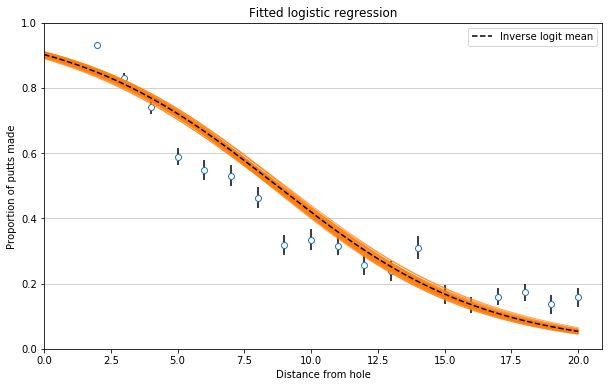

In [118]:
# Plotting
ax = plot_golf_data(data)
distances = np.linspace(0, data["distance"].max(), 200)

# Plotting individual predicted sigmoids for 50 random draws of (a, b)
for idx in np.random.randint(0, len(logit_trace), 50):
    post_logit = scipy.special.expit(logit_trace["a"][idx] + logit_trace["b"][idx] * distances)
    ax.plot(
        distances,
        post_logit,
        lw=1,
        color="tab:orange",
        alpha=.7,
    )
    
# Plotting average prediction over all sampled (a, b)
logit_average = scipy.special.expit(
    logit_trace["a"].reshape(-1, 1) + logit_trace["b"].reshape(-1, 1) * distances,
).mean(axis=0)

ax.plot(
    distances,
    logit_average,
    label = "Inverse logit mean",
    color="k",
    linestyle="--",
)

ax.set_title("Fitted logistic regression")
ax.legend()
plt.show()

We see that:
* The posterior uncertainty is relatively low.
* The fit is OK, but we tend to overestimate the difficulty of making short putts and underestimate the probability of making long puts. 

# 3. Modelling from first principles

Not satisfied with the logistic regression, we contact a golf pro who also happens to have a background in mathematics. She suggests that as an alternative, we could build a model from first principles and fit it to the data.

She provides us with the following sketch (from the [Stan case study](https://mc-stan.org/users/documentation/case-studies/golf.html)):
> The graph below shows a simplified sketch of a golf shot. The dotted line represents the angle within which the ball of radius r must be hit so that it falls within the hole of radius R. This threshold angle is $sin^{−1}\Bigg(\dfrac{R−r}{x}\Bigg)$. The graph, which is not to scale, is intended to illustrate the geometry of the ball needing to go into the hole. 

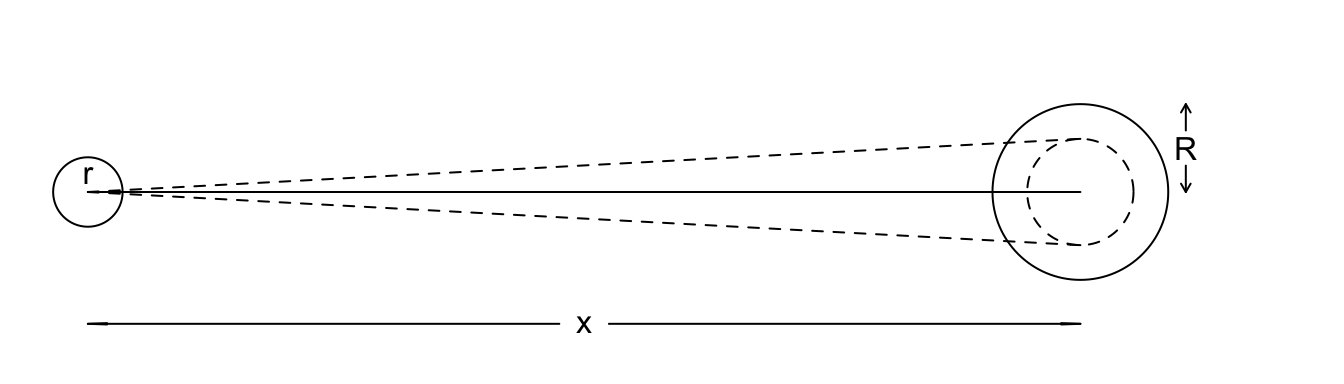

If the angle is less (in absolute value) than the threshold, the show will go in the cup. The mathematically inclined golf pro suggests that we can assume that the putter will attempt to shoot perfectly straight, but that external factors will interfere with this goal. She suggests modelling this uncertainty using a normal distribution centered at 0 (i.e. assume that shots don't deviate systematically to the right or left) with some variance in angle (in radians) given by $\sigma_{\text{angle}}$.

Since our golf expert is also a expert mathematician, she provides us with an expression for the probability that the ball goes in the cup (which is the probability that the angle is less than the threshold):

$$p\Bigg(\vert\text{angle}\vert < sin^{−1}\Bigg(\dfrac{R−r}{x}\Bigg)\Bigg) = 2\Theta\Bigg(\dfrac{1}{\sigma_{\text{angle}}}sin^{−1}\Bigg(\dfrac{R−r}{x}\Bigg)\Bigg) - 1,$$ 

where $\Theta$ is the cumulative normal distribution function.

The full model is then given by

$$y_j \sim \text{Binomial}(n_j, p_j)\\
p_j = 2\Theta\Bigg(\dfrac{1}{\sigma_{\text{angle}}}sin^{−1}\Bigg(\dfrac{R−r}{x}\Bigg)\Bigg) - 1, \quad \text{for} j = 1 \ldots J.$$

Prior to fitting the model, our expert provides us with the appropriate measurements for the golf ball and cup radii. We also plot the probabilities given by the above expression for different values of $\sigma_{\text{angle}}$ to get a feel for the model:

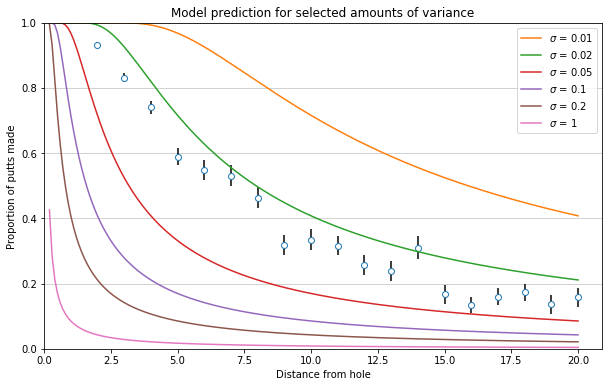

In [119]:
def forward_angle_model(variance_of_shot, distance):
    """Geometry-based probabilities."""
    BALL_RADIUS = (1.68 / 2) / 12
    CUP_RADIUS = (4.25 / 2) / 12
    return 2 * st.norm(0, variance_of_shot).cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / distance)) - 1

# Plotting
variance_of_shot = (0.01, 0.02, 0.05, 0.1, 0.2, 1)
distances = np.linspace(0, data["distance"].max(), 200)
ax = plot_golf_data(data)

for sigma in variance_of_shot:
    ax.plot(distances, forward_angle_model(sigma, distances), label=f"$\sigma$ = {sigma}")

ax.set_title("Model prediction for selected amounts of variance")
ax.legend()
plt.show()

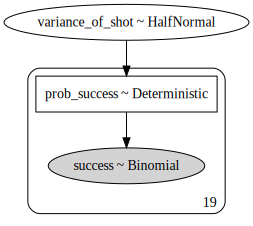

In [120]:
def phi(x):
    """Calculates the standard normal CDF."""
    return 0.5 + 0.5 * tt.erf(x / tt.sqrt(2.))

def angle_model(data):
    """Geometry-based model."""
    BALL_RADIUS = (1.68 / 2) / 12
    CUP_RADIUS = (4.25 / 2) / 12
    
    with pm.Model() as angle_model:
        variance_of_shot = pm.HalfNormal('variance_of_shot')
        prob = 2 * phi(tt.arcsin((CUP_RADIUS - BALL_RADIUS) / data["distance"]) / variance_of_shot) - 1
        prob_success = pm.Deterministic('prob_success', prob)
        success = pm.Binomial('success', n=data["tries"], p=prob_success, observed=data["successes"])
    
    return angle_model

# Plotting model as graph
pm.model_to_graphviz(angle_model(data))

## 3.1 Geometry-based model: Prior predictive checks

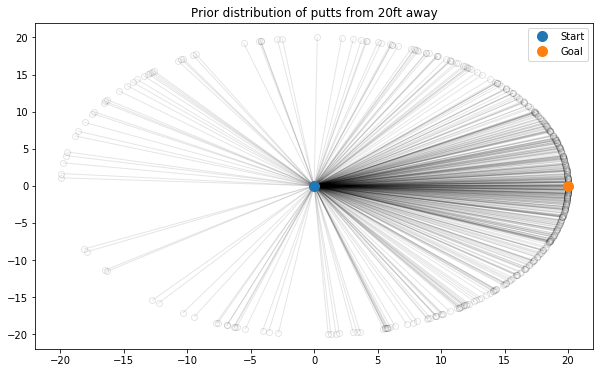

In [121]:
# Drawing 500 samples from the prior predictive distribution
with angle_model(data):
    angle_prior = pm.sample_prior_predictive(500)

# Use these variances to sample an equivalent amount of random angles from a normal distribution
angle_of_shot = np.random.normal(0, angle_prior['variance_of_shot'])
distance = 20

# Calculate possible end positions
end_positions = np.array([
    distance * np.cos(angle_of_shot),
    distance * np.sin(angle_of_shot)
])

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

for endx, endy in end_positions.T:
    ax.plot([0, endx], [0, endy], 'k-o', lw=1, mfc='w', alpha=0.1);

ax.plot(0, 0, 'o', color="tab:blue", label='Start', ms=10)
ax.plot(distance, 0, 'o', color="tab:orange", label='Goal', ms=10)

ax.set_title(f"Prior distribution of putts from {distance}ft away")
ax.legend()
plt.show()

## 3.2 Fitting model

In [122]:
# Draw samples from posterior distribution
with angle_model(data):
    angle_trace = pm.sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [variance_of_shot]
Sampling 4 chains, 0 divergences: 100%|██████████| 44000/44000 [00:05<00:00, 7648.60draws/s]


In [131]:
pm.summary(angle_trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
variance_of_shot,0.027,0.000,0.026,0.027,0.0,0.0,16105.0,16105.0,16162.0,27306.0,1.0
prob_success[0],0.955,0.003,0.949,0.961,0.0,0.0,16115.0,16113.0,16162.0,27306.0,1.0
prob_success[1],0.820,0.006,0.807,0.832,0.0,0.0,16103.0,16101.0,16162.0,27306.0,1.0
prob_success[2],0.685,0.007,0.671,0.698,0.0,0.0,16101.0,16100.0,16162.0,27306.0,1.0
prob_success[3],0.578,0.007,0.565,0.591,0.0,0.0,16100.0,16100.0,16162.0,27306.0,1.0
prob_success[4],0.497,0.006,0.485,0.509,0.0,0.0,16100.0,16100.0,16162.0,27306.0,1.0
prob_success[5],0.434,0.006,0.423,0.445,0.0,0.0,16100.0,16100.0,16162.0,27306.0,1.0
prob_success[6],0.385,0.005,0.375,0.394,0.0,0.0,16100.0,16100.0,16162.0,27306.0,1.0
prob_success[7],0.345,0.005,0.336,0.354,0.0,0.0,16100.0,16100.0,16162.0,27306.0,1.0
prob_success[8],0.312,0.004,0.304,0.320,0.0,0.0,16100.0,16100.0,16162.0,27306.0,1.0


## 3.3 Logistic regression vs. geometry-based model

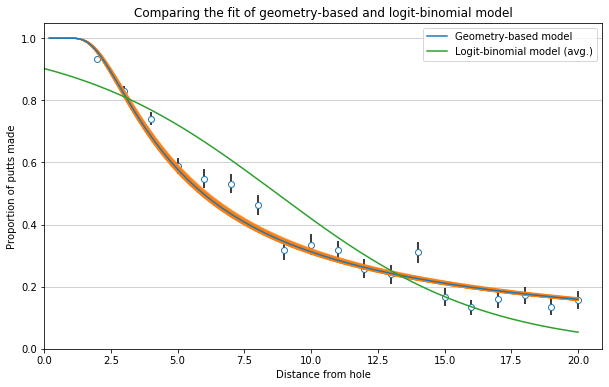

In [136]:
# Plot model
ax = plot_golf_data(data)
distances = np.linspace(0, data["distance"].max(), 200)

for idx in np.random.randint(0, len(angle_trace), 50):
    ax.plot(
        distances,
        forward_angle_model(angle_trace['variance_of_shot'][idx], distances),
        lw=1,
        color="tab:orange",
        alpha=0.7,
    )

# Average of angle model
ax.plot(
    distances,
    forward_angle_model(angle_trace['variance_of_shot'].mean(), distances),
    label='Geometry-based model',
    color="tab:blue",
)

# Compare with average of logit model
ax.plot(distances, logit_average, color="tab:green", label='Logit-binomial model (avg.)')

ax.set_title("Comparing the fit of geometry-based and logit-binomial model")
ax.set_ylim([0, 1.05])
ax.legend()
plt.show()

In [129]:
# Comparing models using WAIC (Watanabe-Akaike Information Criterion)
models = {
    "logit": logit_trace,
    "geometry": angle_trace,
}
pm.compare(models)

/Users/sean/miniconda3/envs/fagdag/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
geometry,0,177.503,7.8254,0,1,137.361,0,True,deviance
logit,1,425.314,49.1085,247.811,1.23765e-10,24.9101,121.77,True,deviance


## 3.4 Geometry-based model: Posterior predictive check

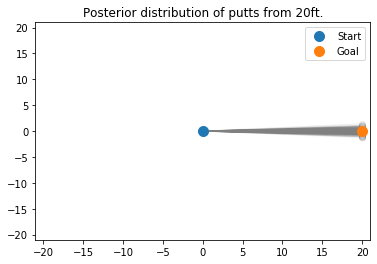

In [127]:
variances = np.random.choice(angle_trace['variance_of_shot'].flatten())

# Randomly sample putt variances from posterior
angle_of_shot = np.random.normal(0, variances, 500)  # radians
distance = 20

# Calculate end positions
end_positions = np.array([
    distance * np.cos(angle_of_shot),
    distance * np.sin(angle_of_shot)
])

# Plotting
fig, ax = plt.subplots()

for endx, endy in end_positions.T:
    ax.plot([0, endx], [0, endy], '-o', color="gray", lw=1, mfc='w', alpha=0.05);

ax.plot(0, 0, 'o', color="tab:blue", label='Start', ms=10)
ax.plot(distance, 0, 'o', color="tab:orange", label='Goal', ms=10)

ax.set_xlim(-21, 21)
ax.set_ylim(-21, 21)
ax.set_title(f"Posterior distribution of putts from {distance}ft.")

ax.legend();